In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [9]:
from waveimage import calc_U

In [26]:
class Obj:
    pass

#### Tenseurs de données

In [75]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor

In [76]:
def wave_tensor_carbon_copy(wave_tensor_ref, batch_size):
    wave_tensor = init_wave_tensor(batch_size)
    for h in range(6):
        for i in range(batch_size):
            wave_tensor[h][i] = np.copy(wave_tensor_ref[h][0])
    return wave_tensor

In [77]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

# Construction du réseau

In [12]:
DEPTH_WAV = 3

DIM_5 = 16
WIDTH = 2

DEPTH_4 = 32
DIM_4 = DIM_5 / WIDTH # 8

DEPTH_3 = 64
DIM_3 = DIM_4 / WIDTH # 4

DEPTH_2 = 128
DIM_2 = DIM_3 / WIDTH # 2

DEPTH_1 = 256
DIM_1 = DIM_2 / WIDTH # 1

DIM_HIDDEN = 512

NB_LABEL = 10

STD = 1.

In [13]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev = stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

In [14]:
x_5 = tf.placeholder(tf.float32, shape=[None, DIM_5, DIM_5, DEPTH_WAV])
x_4 = tf.placeholder(tf.float32, shape=[None, DIM_4, DIM_4, DEPTH_WAV])
x_3 = tf.placeholder(tf.float32, shape=[None, DIM_3, DIM_3, DEPTH_WAV])
x_2 = tf.placeholder(tf.float32, shape=[None, DIM_2, DIM_2, DEPTH_WAV])
x_1 = tf.placeholder(tf.float32, shape=[None, DIM_1, DIM_1, DEPTH_WAV])
x_0 = tf.placeholder(tf.float32, shape=[None, 1, 1, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
batch_phase = tf.placeholder(tf.bool, name='bn_phase')

In [15]:
# Paramètres
W_conv_54 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4], \
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_54")
# Graph construction
h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_4') 
#h_pool_4 = tf.nn.max_pool(h_conv_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_4')
#h_pool_4_bn = tf.contrib.layers.batch_norm(h_pool_4, center=True, scale=True, is_training=batch_phase, scope='h_pool_4', updates_collections=None)
z_conv_4 = tf.nn.relu(h_conv_4)

#h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_4') 
#h_conv_4_bn = tf.contrib.layers.batch_norm(h_conv_4, center=True, scale=True, is_training=batch_phase, scope='h_conv_4', updates_collections=None)
#z_conv_4 = tf.nn.relu(h_conv_4_bn)

cat_conv_4 = tf.concat((z_conv_4, x_4), axis = 3)


In [16]:
# Paramètres
W_conv_43 = weight_variable([WIDTH, WIDTH, DEPTH_4 + DEPTH_WAV, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_4 + DEPTH_WAV)), \
                            name = "W_conv_43")

h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3') 
#h_pool_3 = tf.nn.max_pool(h_conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3')
#h_pool_3_bn = tf.contrib.layers.batch_norm(h_pool_3, center=True, scale=True, is_training=batch_phase, scope='h_pool_3', updates_collections=None)
z_conv_3 = tf.nn.relu(h_conv_3)

# Graph construction
#h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_3') 
#h_conv_3_bn = tf.contrib.layers.batch_norm(h_conv_3, center=True, scale=True, is_training=batch_phase, scope='h_conv_3', updates_collections=None)
#z_conv_3 = tf.nn.relu(h_conv_3_bn)

cat_conv_3 = tf.concat((z_conv_3, x_3), axis = 3)


In [17]:
# Paramètres
W_conv_32 = weight_variable([WIDTH, WIDTH, DEPTH_3 + DEPTH_WAV, DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_3 + DEPTH_WAV)), \
                            name = "W_conv_32")

# Graph construction
h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2') 
#h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2')
#h_pool_2_bn = tf.contrib.layers.batch_norm(h_pool_2, center=True, scale=True, is_training=batch_phase, scope='h_pool_2', updates_collections=None)
z_conv_2 = tf.nn.relu(h_conv_2)

#h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_2') 
#h_conv_2_bn = tf.contrib.layers.batch_norm(h_conv_2, center=True, scale=True, is_training=batch_phase, scope='h_conv_2', updates_collections=None)
#z_conv_2 = tf.nn.relu(h_conv_2_bn)

cat_conv_2 = tf.concat((z_conv_2, x_2), axis = 3)


In [18]:
# Paramètres
W_conv_21 = weight_variable([WIDTH, WIDTH, DEPTH_2 + DEPTH_WAV, DEPTH_1],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_2 + DEPTH_WAV)), \
                            name = "W_conv_21")

h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1') 
#h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1')
#h_pool_1_bn = tf.contrib.layers.batch_norm(h_pool_1, center=True, scale=True, is_training=batch_phase, scope='h_pool_1', updates_collections=None)
z_conv_1 = tf.nn.relu(h_conv_1)

# Graph construction
#h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_1') 
#h_conv_1_bn = tf.contrib.layers.batch_norm(h_conv_1, center=True, scale=True, is_training=batch_phase, scope='h_conv_1', updates_collections=None)
#z_conv_1 = tf.nn.relu(h_conv_1_bn)

cat_conv_1 = tf.concat((z_conv_1, x_1, x_0), axis = 3)
z_flat1 = tf.reshape(cat_conv_1, [-1, DEPTH_1 + DEPTH_WAV + 1])

In [19]:
W_hidden = weight_variable([DEPTH_1 + DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_WAV + 1), name = "W_hidden")
h_hidden = tf.matmul(z_flat1, W_hidden)
z_hidden = tf.nn.relu(h_hidden)
z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

In [20]:
W_readout = weight_variable([DIM_HIDDEN, NB_LABEL], stddev = STD / DIM_HIDDEN, name = "W_readout")
y_hat_logit = tf.matmul(z_hidden_drop, W_readout)

In [21]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat_logit))

l1_regularizer = tf.contrib.layers.l1_regularizer(
   scale=0.005, scope=None
)
weights = tf.trainable_variables() # all vars of your graph
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

regularized_loss = classif_loss #+ regularization_penalty # this loss needs to be min

In [22]:
train = tf.train.AdamOptimizer(1e-4).minimize(regularized_loss)

In [23]:
correct_prediction = tf.equal(tf.argmax(y_hat_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [175]:
file_name = "models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts"
saver.restore(sess,       file_name + ".ckpt")
mem    = pickle.load(open(file_name + "_mem.pkl", "rb"))

INFO:tensorflow:Restoring parameters from models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts.ckpt


#### Calcul des ascendants

In [28]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [29]:
print calcule_asc_path(5,(15,3))

[(5, (15, 3)), (4, (7, 1)), (3, (3, 0)), (2, (1, 0)), (1, (0, 0)), (0, (0, 0))]


#### Generators

In [30]:
mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))

In [31]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
        #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
    else:
        return np.zeros(3)

In [32]:
def monte_carlo_generator(c, h, u):
    if np.random.random() > rho[c][h][u]:
        return np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u], 1)[0]
    else:
        return np.zeros(3)

## Parcours predictif

In [133]:
def predictive_search(sess, z_ref, actions_set, batch_ref = None):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5 #h_max - 1
    
    ## Parcours predictif
    batch_size = len(actions_set)
    
    dict_u = {}
    
    if batch_ref is not None:
        batch_predictive_tensor = wave_tensor_carbon_copy(batch_ref, batch_size)
    else:
        batch_predictive_tensor =  init_wave_tensor(batch_size)
                
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        
        for (h_path, u_path) in liste_path[:-1]:
            v_predictive = argmax_generator(z_ref, h_path, u_path)
            batch_predictive_tensor[h_path][i][u_path[0]][u_path[1]][:]  = v_predictive #np.copy(batch_full[h_path][0][u_path[0]][u_path[1]][:] )

    log_score_path = y_hat_logit.eval(feed_dict={ x_5: batch_predictive_tensor[5],\
                                    x_4: batch_predictive_tensor[4],\
                                    x_3: batch_predictive_tensor[3],\
                                    x_2: batch_predictive_tensor[2],\
                                    x_1: batch_predictive_tensor[1],\
                                    x_0: batch_predictive_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
    
    #pi_path = sess.run(tf.nn.softmax(log_score_path)) #!!TROP LENT!!
    pi_path = np.zeros(batch_size)
    for i in range(batch_size):
        pi_path[i] = np.exp(log_score_path[i, z_ref]) / np.sum(np.exp(log_score_path[i]))
    
    ## 3 ##
    #i_max = np.where(pi_path[:, z_ref] == max(pi_path[:, z_ref]))[0][0]
    i_max = np.where(pi_path == max(pi_path))[0][0]
    #return dict_u[i_max], pi_path[i_max, z_ref]
    return dict_u[i_max], pi_path[i_max]
    

In [153]:
def predictive_search_diff(sess, z_ref, log_score, actions_set, batch_ref = None):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5 #h_max - 1
    
    ## Parcours predictif
    batch_size = len(actions_set)
    
    log_score_ref = np.zeros((batch_size, len(log_score)))
    for i in range(batch_size):
        log_score_ref[i] = log_score
        
    if batch_ref is not None:
        batch_predictive_tensor =  wave_tensor_carbon_copy(batch_ref, batch_size)
    else:
        batch_predictive_tensor = init_wave_tensor(batch_size)
        
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        for (h_path, u_path) in liste_path[:-1]:
            v_predictive = argmax_generator(z_ref, h_path, u_path)
            batch_predictive_tensor[h_path][i][u_path[0]][u_path[1]][:]  = v_predictive #np.copy(batch_full[h_path][0][u_path[0]][u_path[1]][:] )

    log_score_path = y_hat_logit.eval(feed_dict={ x_5: batch_predictive_tensor[5],\
                                    x_4: batch_predictive_tensor[4],\
                                    x_3: batch_predictive_tensor[3],\
                                    x_2: batch_predictive_tensor[2],\
                                    x_1: batch_predictive_tensor[1],\
                                    x_0: batch_predictive_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
    log_score_diff = log_score_path - log_score_ref
    pi_diff = np.zeros(batch_size)
    for i in range(batch_size):
        pi_diff[i] = np.exp(log_score_diff[i, z_ref]) / np.sum(np.exp(log_score_diff[i]))
    #pi_path = sess.run(tf.nn.softmax(log_score_path))
    
    ## 3 ##
    i_max = np.where(pi_diff == max(pi_diff))[0][0]
    #print i_max
    return dict_u[i_max], log_score_diff[i_max, :]
    

## Saliency maps calculation

#### Basic saliency map : `pi_predictive[c][u]` (h = 5) 

In [67]:
h_ref = 5
pi_predictive = {}
for c in range(10):
    print c
    pi_predictive[c] = {}

    mem_h_u = []
    actions_set = {}
    for i in range(16):
        for j in range(16):
            actions_set[(i, j)] = 1

    batch_test = init_wave_tensor(len(actions_set))
    for i, u_ref in enumerate(actions_set):
        liste_path = calcule_asc_path(h_ref, u_ref)
        for (h_path, u_path) in liste_path[:-1]:
            v_predictive = argmax_generator(c, h_path, u_path)
            batch_test[h_path][i][u_path[0]][u_path[1]][:] = v_predictive
    
    log_score_test = y_hat_logit.eval(feed_dict={ x_5: batch_test[5],\
                                    x_4: batch_test[4],\
                                    x_3: batch_test[3],\
                                    x_2: batch_test[2],\
                                    x_1: batch_test[1],\
                                    x_0: batch_test[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
    
    pi_test = sess.run(tf.nn.softmax(log_score_test))
    #print pi_test[0][c]
    
    
    for i, u_tilde in enumerate(actions_set) :    
        pi_predictive[c][u_tilde] = pi_test[i][c]
       
        

0
1
2
3
4
5
6
7
8
9


#### Effective saliency map : `pi_predictive_eff[c][u]` (h = 5) 

In [149]:
if True : #not os.path.isfile("mnist-waveimage-saliency-map-backbone-CNN-parts.pkl"):
    h_ref = 5
    pi_predictive_eff = {}
    for c in range(10):
        print c
        pi_predictive_eff[c] = {}

        mem_h_u = []
        actions_set = {}
        for i in range(16):
            for j in range(16):
                actions_set[(i, j)] = 1
        
        batch_ref = init_wave_tensor(1)
        pi_ref = .1 
        
        #w_aff = WaveImage()
        
        while len(actions_set) > 0 :
            mem_pi = pi_ref
            u_tilde, pi_ref = predictive_search(sess, c, actions_set, batch_ref)        
            pi_predictive_eff[c][u_tilde] = pi_ref - mem_pi

            actions_set.pop(u_tilde) 
            
            #liste_path = calcule_asc_path(h_ref, u_tilde)
            #for (h_path, u_path) in liste_path[:-1]:
            #    if (h_path, u_path) not in mem_h_u:
            #        mem_h_u += [(h_path, u_path)]    
            
            #print u_tilde
            liste_path = calcule_asc_path(h_ref, u_tilde)
            #print liste_path
            for (h_path, u_path) in liste_path[:-1]:
                v_predictive = argmax_generator(c, h_path, u_path)
                #print v_predictive
                batch_ref[h_path][0][u_path[0]][u_path[1]][:] = v_predictive
                #w_aff.set_data(h_path, u_path, v_predictive)
            
            if False:
                w_aff = WaveImage()
                for (h,u) in mem_h_u :
                    w_aff.set_data(h, u, batch_ref[h][0][u[0]][u[1]][:])
                plt.figure(figsize=(3,3))
                plt.imshow(w_aff.get_image(), interpolation='nearest', cmap='gray_r')
                wait = raw_input('')

        #print 'CHOIX :', (h, u)
    pickle.dump(pi_predictive_eff,  open("mnist-waveimage-saliency-map-backbone-CNN-parts.pkl", "wb"))
else:
    pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-backbone-CNN-parts.pkl", "rb"))            
        

0
1
2
3
4
5
6
7
8
9


####  Saliency map from posterior difference : `pi_predictive_diff[c][u]` (h_ref = 5) 
!! mem_h_u est inutile ici ( et pour tout ce qui concerne le calcul du posterieur par complétion)

In [176]:
if True : #not os.path.isfile("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl"):
    h_ref = 5
    pi_predictive_diff = {}
    for c in range(10):
        print c
        
        # Initialisations
        pi_predictive_diff[c] = {}
        
        actions_set = {}
        for i in range(16):
            for j in range(16):
                actions_set[(i, j)] = 1
        
        batch_ref = init_wave_tensor(1)
        
        log_score = np.zeros(10)
        # Calcul
        while len(actions_set) > 0 :    
            u_tilde, log_score_diff = predictive_search_diff(sess, c, log_score, actions_set, batch_ref)    
            #pi_diff = sess.run(tf.nn.softmax(log_score_diff)) ## !!! ralentit enormement !!!??
            pi_predictive_diff[c][u_tilde] = np.exp(log_score_diff[c])/np.sum(np.exp(log_score_diff))
            log_score += log_score_diff
            actions_set.pop(u_tilde) 
            #liste_path = calcule_asc_path(h_ref, u_tilde)
            #for (h_path, u_path) in liste_path[:-1]:
            #    if (h_path, u_path) not in mem_h_u:
            #    mem_h_u += [(h_path, u_path)]
            liste_path = calcule_asc_path(h_ref, u_tilde)
            #print liste_path
            for (h_path, u_path) in liste_path[:-1]:
                v_predictive = argmax_generator(c, h_path, u_path)
                #print v_predictive
                batch_ref[h_path][0][u_path[0]][u_path[1]][:] = v_predictive
                #w_aff.set_data(h_path, u_path, v_predictive)
        #print 'CHOIX :', (h, u)
    pickle.dump(logit_predictive_diff,  open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "wb"))
else:
    logit_predictive_diff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))            
        

0
1
2
3
4
5
6
7
8
9


### Reconstruction

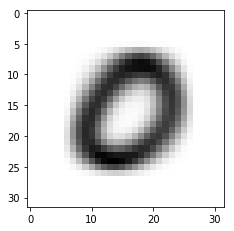

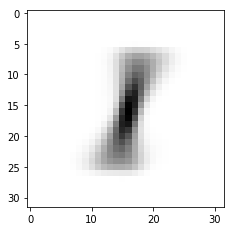

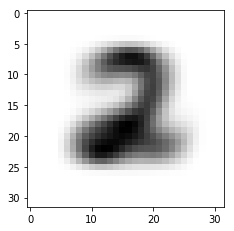

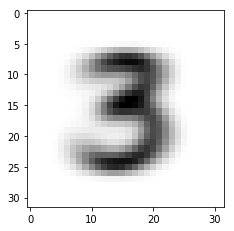

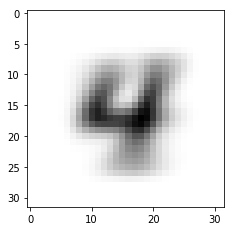

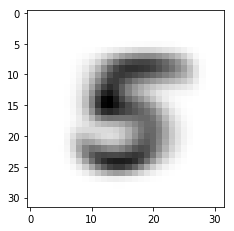

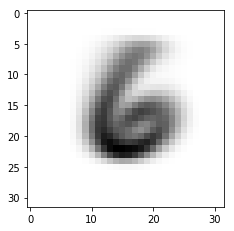

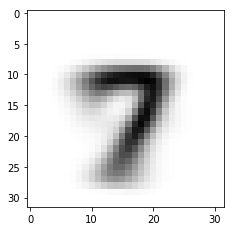

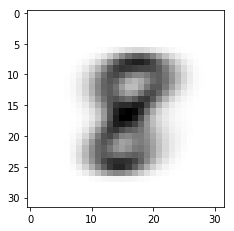

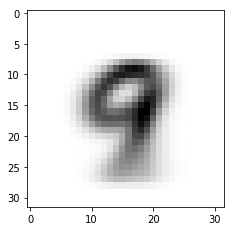

In [52]:
avg_image = {}
for c in range(10):
    w = WaveImage()
    for h in range(6):
        for u in calc_U((32, 32), h, 6):
            w.set_data( h, u, mu[c][h][u] * (1 - rho[c][h][u]))
    avg_image[c] = w.get_image()
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(w.get_image(), interpolation='nearest', cmap='gray_r')



In [48]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [49]:
def affiche_path_mnist(path_i, path_j):
    col_max = max(15, len(path_i))
    colors = plt.cm.rainbow(np.linspace(0, 1, col_max))
    b_moins = -.5
    b_plus = 31.5
    for cpt in range(len(path_i) - 1):
        plt.plot(path_j[cpt:cpt + 2],path_i[cpt:cpt + 2], color = colors[col_max - cpt - 1], linewidth= 3)
    #plt.plot(path_j,path_i,'r+',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

In [107]:
def affiche_path(pi_predictive): 
    pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive)
    for c in range(10):
        image_moy = avg_image[c] #np.mean(np.array(data_visu[c]),0)
        plt.figure(figsize=(12,8))
        plt.subplot(131)
        plt.imshow(image_moy, interpolation='nearest', cmap='gray_r')
        plt.title(c)
        path_i = []
        path_j = []
        image_pi = np.zeros((14,14))
        for cpt in range(6):
            (pi_pred, u) = pi_predictive_sorted[c][-1-cpt]
            #(pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
            #print c,pi_pred
            path_i += [u[0] * 2 + 1.5]
            path_j += [u[1] * 2 + 1.5]
        affiche_path_mnist(path_i, path_j)
        plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)

        plt.subplot(132)
        sal_map = np.zeros((16, 16))
        for i in range(16):
            for j in range(16):
                sal_map[i,j] = pi_predictive[c][(i,j)] 



        plt.imshow(sal_map, interpolation='nearest', cmap = 'gist_heat_r', vmin = 0, vmax = 1)

    

In [172]:

for c in pi_predictive_eff:
    print c
    pi_test = 0
    for u in  pi_predictive_eff[c]:
        pi_test += pi_predictive_diff[c][u]
    print pi_test
      

0
27.5496333356
1
27.620535852
2
27.2731966727
3
28.2379894916
4
27.6535904678
5
27.9954121549
6
27.9054688579
7
27.8738464332
8
27.5291863232
9
27.4306065292


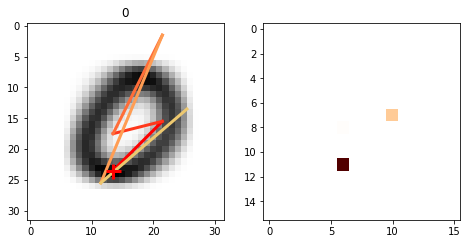

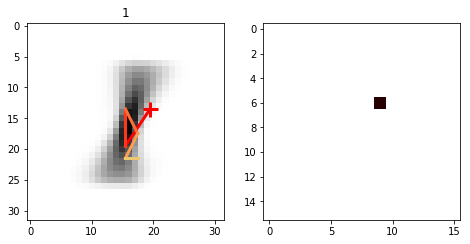

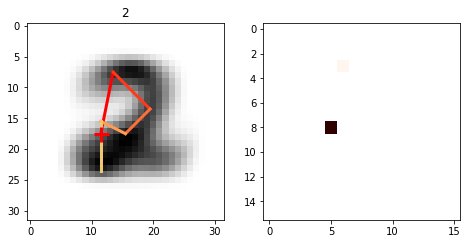

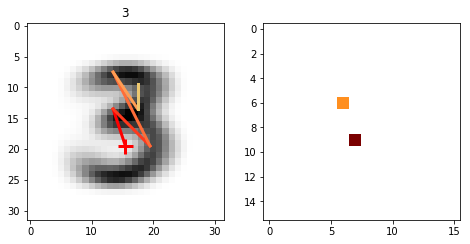

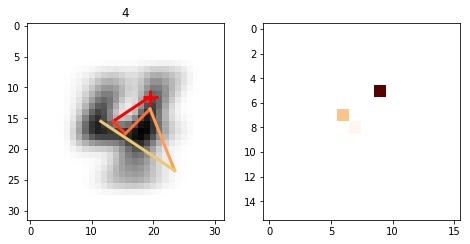

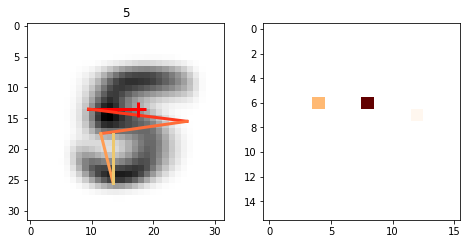

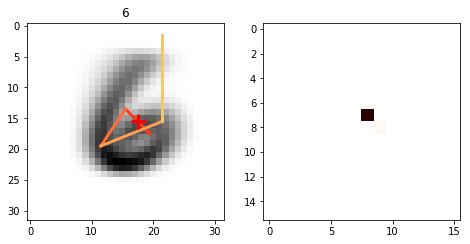

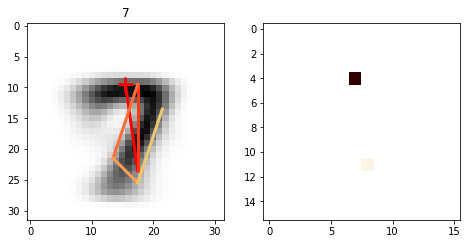

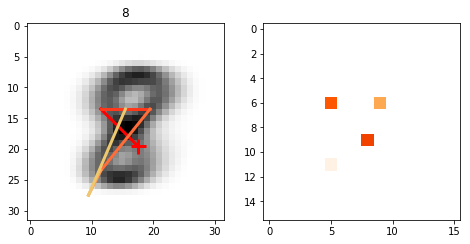

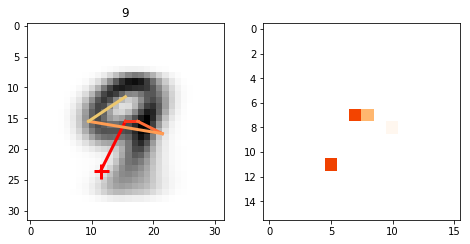

In [173]:
affiche_path(pi_predictive_eff)

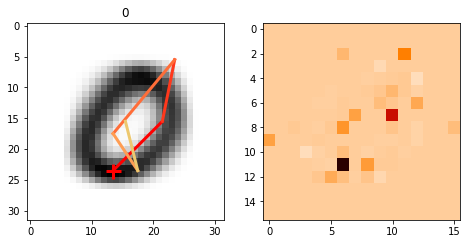

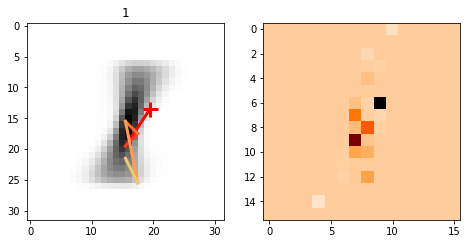

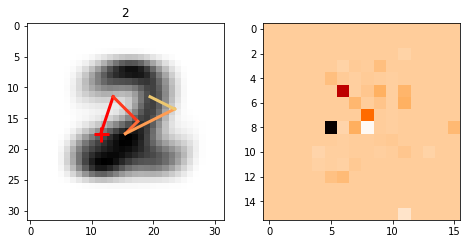

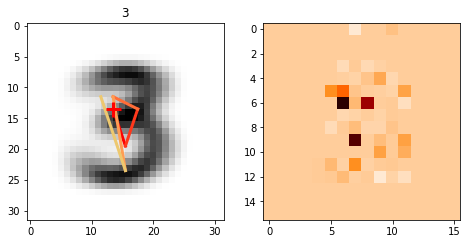

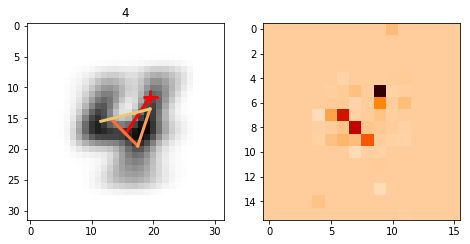

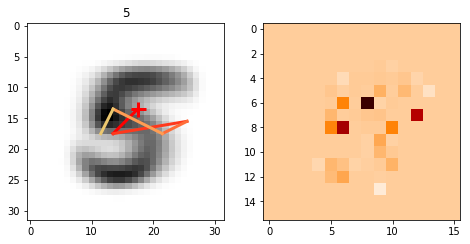

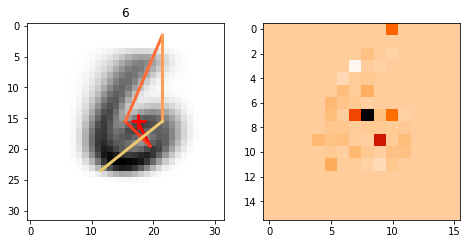

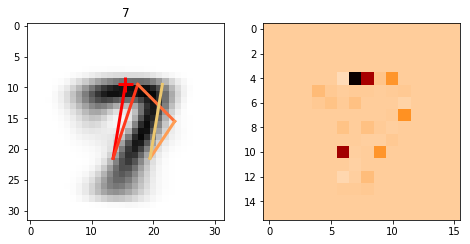

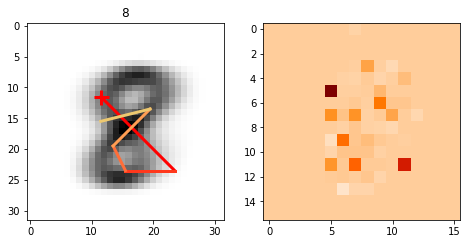

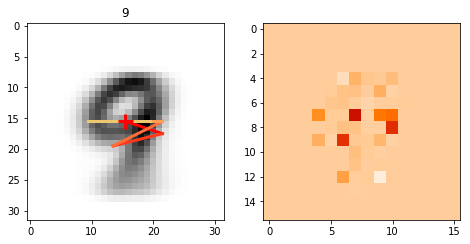

In [174]:
affiche_path(pi_predictive_diff)

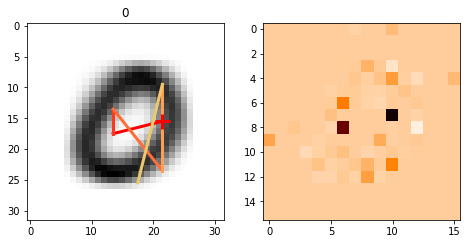

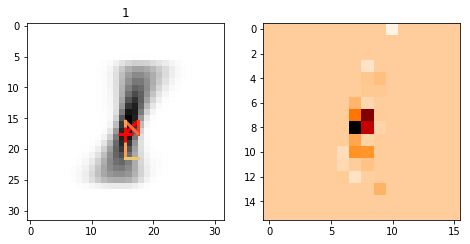

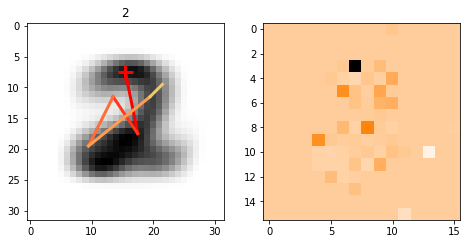

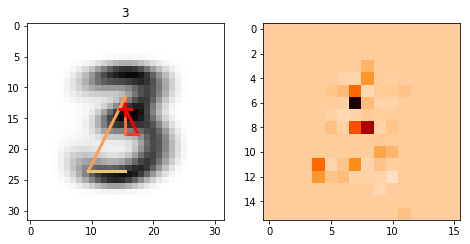

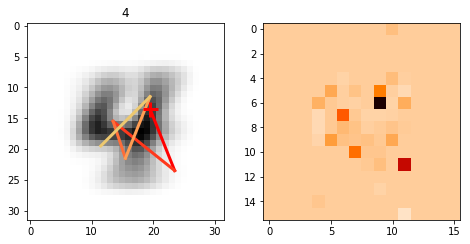

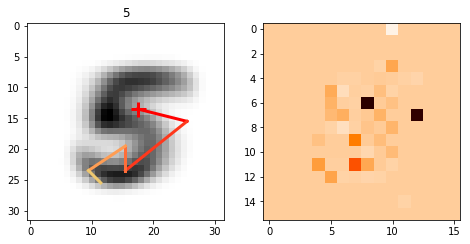

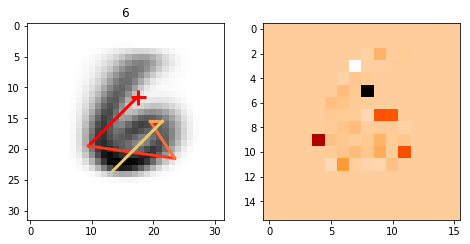

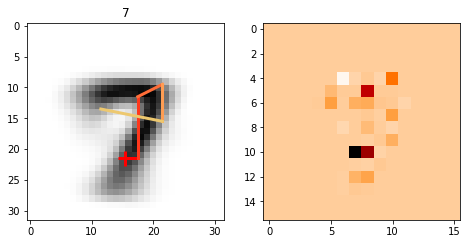

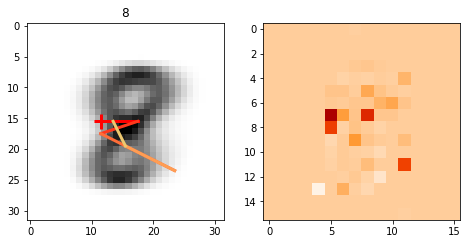

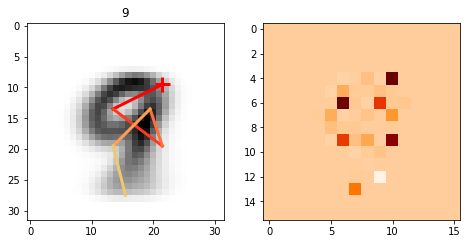

In [177]:
affiche_path(pi_predictive_diff)